In [1]:
#step 1 Encoder block
#attention func, Attentionhead and Mutilhead attention
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math

In [2]:
def scaled_dot_attention(Q,K,V,mask=None):
    #Query key dot product 
    q_k = torch.bmm(Q,K.mT)
    #d_k for scaling
    d_k = torch.tensor(K.size(-1),dtype=torch.float32)
    scaled_qk = q_k/torch.sqrt(d_k)
    #apply mask before softmax
    if mask is not None:
        scaled_qk = scaled_qk.masked_fill(mask==0,-1e9)
    #softmax
    soft_q_k = F.softmax(scaled_qk,dim=1)
    #multiply weights with values
    w_v = torch.bmm(soft_q_k,V)
    return w_v

In [3]:
class AttentionHead(nn.Module):
    def __init__(self,embedding_dim,head_dim):
        super(AttentionHead,self).__init__()
        self.embedding_dim = embedding_dim
        self.head_dim = head_dim
        self.Q = nn.Linear(embedding_dim,head_dim)
        self.K = nn.Linear(embedding_dim,head_dim)
        self.V = nn.Linear(embedding_dim,head_dim)
    def forward(self,x,mask=None):
        q = self.Q(x)
        k = self.K(x)
        v = self.V(x)
        attention = scaled_dot_attention(q,k,v,mask)
        return attention 

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self,embedding_dim,num_heads):
        super(MultiHeadAttention,self).__init__()
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.head_dim = embedding_dim//num_heads
        self.heads = nn.ModuleList([AttentionHead(self.embedding_dim,self.head_dim) for _ in range(self.num_heads)])
        self.Wo = nn.Linear(embedding_dim,embedding_dim)
    def forward(self,x,mask=None):
        scores = []
        for head in self.heads:
            scores.append(head(x,mask))
        scores = torch.cat(scores,2)
        attention_representation = self.Wo(scores)
        return attention_representation

In [5]:
class FeedForwardNetwork(nn.Module):
    def __init__(self,embedding_dim,p=0.3):
        super(FeedForwardNetwork,self).__init__()
        self.embedding_dim = embedding_dim
        self.d_ff = embedding_dim*4
        self.dropout = nn.Dropout(p)
        self.linear1 = nn.Linear(embedding_dim,self.d_ff)
        self.linear2 = nn.Linear(self.d_ff,embedding_dim)
    def forward(self,x):
        x = self.linear1(x)
        x = F.gelu(self.dropout(x))
        x = self.linear2(x)
        return x       

### Embedding

In [6]:
#using learnable positional embedding
class PosEmbedding(nn.Module):
    def __init__(self,vocab_size,max_position,hidden_dim,p=0.2):
        super(PosEmbedding,self).__init__()
        self.vocab_size = vocab_size
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size,self.hidden_dim)
        self.pos_embedding = nn.Embedding(max_position,self.hidden_dim)
        self.layernorm = nn.LayerNorm(hidden_dim)
    def forward(self,input_ids):
        seq_len = len(input_ids)
        positions = torch.arange(0, seq_len, dtype=torch.long).unsqueeze(0)
        pos_emb = self.pos_embedding(positions)
        token_emb = self.embedding(input_ids)
        emb = self.layernorm(token_emb+pos_emb)
        return emb   

## 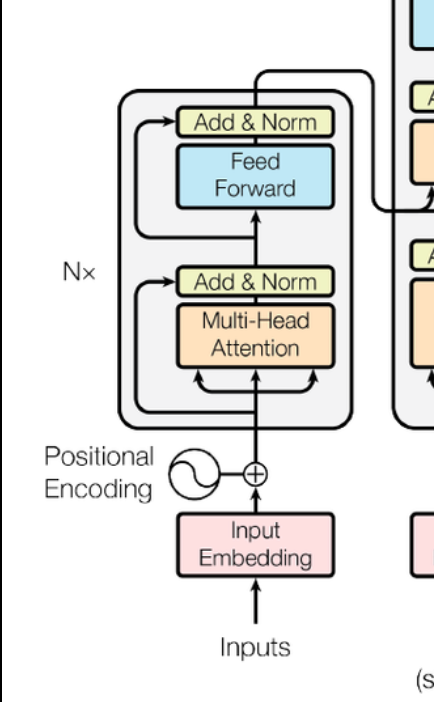

### Encoder

In [7]:
#using post layer norm
class Encoder(nn.Module):
    def __init__(self,hidden_dim,num_heads):
        super(Encoder,self).__init__()
        self.hidden_dim = hidden_dim
        self.feedforward = FeedForwardNetwork(hidden_dim)
        self.multihead = MultiHeadAttention(hidden_dim,num_heads)
        self.layernorm_attention = nn.LayerNorm(hidden_dim)
        self.layernorm_feedforward = nn.LayerNorm(hidden_dim)
    def forward(self,emb):
        att_emb = self.multihead(emb)
        emb = self.layernorm_attention(att_emb + emb)
        emb = self.layernorm_feedforward(emb + self.feedforward(emb))
        return emb

In [8]:
encoder = Encoder(hidden_dim=10,num_heads=2)

In [9]:
def process_text(text):
    text = '[CLS]' + text + '[SEP]'
    input_ids = [vocab.get(token,vocab['[UNK]']) for token in text.lower().split()]
    emb = embedding_layer(torch.tensor(input_ids))
    #create 12 encoders
    encoders = nn.ModuleList([Encoder(10,2) for _ in range(12)])
    for encoder in encoders:
        emb = encoder(emb)
    return emb

In [13]:
vocab = {'[MASK]':0,'[PAD]':1,'[SEP]':2,'[CLS]':3,'hello':4,'how':5,'are':6,'you':7,'adi':8,'i':9,'am':10,'[UNK]':11,',':12,'.':13,'?':14}
vocab_size = len(vocab)
hidden_dim = 10
max_pos = 10
embedding_layer = PosEmbedding(vocab_size,max_pos,hidden_dim)
encoder = Encoder(hidden_dim=10,num_heads=2)

In [16]:
text = "Hello how are you ? I Am Adi"
text_embeddings = process_text(text)

In [14]:
text_embeddings.shape

torch.Size([1, 8, 10])

In [15]:
text_embeddings

tensor([[[ 1.3785,  0.0503,  0.7445, -2.5712, -0.2263,  0.5293,  0.3474,
           0.3200,  0.0402, -0.6129],
         [ 0.7406,  0.5114,  0.6831, -1.9050, -1.2556,  0.5662,  0.1533,
           0.0169, -0.9911,  1.4802],
         [ 2.2567, -0.5684,  0.9441, -0.7246,  0.4491,  0.6995, -0.5866,
          -0.7417, -0.6525, -1.0756],
         [ 1.2537,  1.0767,  1.1560, -0.4969, -1.2271, -0.2856, -0.1589,
           0.8368, -0.3521, -1.8025],
         [ 1.6923, -0.8508,  0.9353, -0.8926, -1.6311,  0.8892,  0.5033,
           0.1359,  0.2062, -0.9876],
         [-0.1099,  1.4364, -0.4137, -1.5236, -0.9545,  1.2486,  0.5203,
          -1.2434,  1.0696, -0.0299],
         [ 0.9005, -0.5821,  1.2762, -2.0772,  0.6271,  0.5542, -1.1111,
           0.8622,  0.0270, -0.4769],
         [ 1.2078,  0.9515,  0.4320, -1.6746, -0.3896, -0.9054, -0.2313,
           0.7499,  1.1643, -1.3046]]], grad_fn=<NativeLayerNormBackward0>)